In [1]:
# importing relevant libraries

import pandas as pd
import matplotlib.pyplot as plt
from ast import literal_eval 
from transformers import BertTokenizer, BertModel
import torch
from torch import nn
from torch.optim import Adam
import pytorch_lightning as pl
from torch.utils.data import TensorDataset,DataLoader,SequentialSampler
from torch.nn.utils import clip_grad_norm_
from keras_preprocessing.sequence import pad_sequences
import numpy as np
from tqdm import tqdm

In [2]:
train_data= pd.read_csv("tsd_train.csv")
test_data= pd.read_csv("tsd_test.csv")
train_data.head()

,spans,text
0,"[8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,...",Another violent and aggressive immigrant killi...
1,"[33, 34, 35, 36, 37, 38, 39]","I am 56 years old, I am not your fucking junio..."
2,"[0, 1, 2, 3]","Damn, a whole family. Sad indeed."
3,"[7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]",What a knucklehead. How can anyone not know th...
4,"[32, 33, 34, 35, 36, 37, 38]","""who do you think should do the killing?""\n\nA..."


In [3]:
def clean_spans(df, col):
    # Initialize an empty list to store the cleaned values
    clean_list = []
    
    # Iterate over each value in the specified column of the DataFrame
    for i in list(df[col]):
        # Convert the string representation of a list to an actual list using literal_eval
        clean_list.append(literal_eval(str(i)))
    
    # Replace the values in the specified column with the cleaned list
    df[col] = clean_list
    
    # Return the updated DataFrame
    return df

# Clean the 'spans' column in the train_data DataFrame
train_data = clean_spans(train_data, 'spans')

# Clean the 'spans' column in the test_data DataFrame
test_data = clean_spans(test_data, 'spans')

In [4]:
# Create a tokenizer using the BERT base uncased model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

# Custom tokenizer function that uses the BERT tokenizer
def custom_tokenizer(text):
    return tokenizer.tokenize(text)

# Function to retrieve words from spans
def retrieve_word_from_span(lst_span, text):
    i = 0
    token = []
    a = 0
    word = []
    
    while (i < (len(lst_span) - 1)):
        if (lst_span[i] != (lst_span[i+1] - 1)):
            token.append(lst_span[a:(i+1)])
            a = i + 1
        elif i == (len(lst_span) - 2):
            token.append(lst_span[a:i+2])

        i = i + 1

    for t in token:
        word.append(text[t[0]:(t[len(t)-1]) + 1])

    return word

# Function to retrieve words from spans for all examples in the DataFrame
def span_retrieved(df):
    token_labels = []

    for i in range(len(df)):
        token_labels.append(retrieve_word_from_span(df['spans'][i], df['text'][i]))
    
    return token_labels

# Function to convert spans into token labels in the DataFrame
def span_convert(df):
    MAX_LEN = 0
    token_labels = []

    for i in range(0, len(df['text'])):
        token_labels.append(retrieve_word_from_span(df['spans'][i], df['text'][i]))

    lst_seq = []
    for i in range(0, len(df['text'])):
        token = custom_tokenizer(df['text'][i])
        if len(token) > MAX_LEN:
            MAX_LEN = len(token)
            
        seq = np.zeros(len(token), dtype=int)
        for j in range(0, len(token)):
            for t in token_labels[i]:
                if token[j] in custom_tokenizer(t):
                    seq[j] = 1
        lst_seq.append(seq)

    bert_token_list = []
    for i in df['text']:
        bert_token_list.append(tokenizer.tokenize(i))     

    df['toxic_tokens'], df['bert_tokens'], df['token_labels'] = token_labels, bert_token_list, lst_seq
    
    return df


In [5]:
train_data1=span_convert(train_data)
test_data1= span_convert(test_data)
train_data1.head()

,spans,text,toxic_tokens,bert_tokens,token_labels
0,"[8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,...",Another violent and aggressive immigrant killi...,[violent and aggressive immigrant],"[another, violent, and, aggressive, immigrant,...","[0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
1,"[33, 34, 35, 36, 37, 38, 39]","I am 56 years old, I am not your fucking junio...",[fucking],"[i, am, 56, years, old, ,, i, am, not, your, f...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, ..."
2,"[0, 1, 2, 3]","Damn, a whole family. Sad indeed.",[Damn],"[damn, ,, a, whole, family, ., sad, indeed, .]","[1, 0, 0, 0, 0, 0, 0, 0, 0]"
3,"[7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]",What a knucklehead. How can anyone not know th...,[knucklehead],"[what, a, kn, ##uck, ##le, ##head, ., how, can...","[0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,"[32, 33, 34, 35, 36, 37, 38]","""who do you think should do the killing?""\n\nA...",[killing],"["", who, do, you, think, should, do, the, kill...","[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."


In [8]:
def maxlen(df_train, df_test):
    # Calculate the maximum length of 'bert_tokens' in the train_data DataFrame
    max_len_train = max([len(x) for x in df_train['bert_tokens']])
    
    # Calculate the maximum length of 'bert_tokens' in the test_data DataFrame
    max_len_test = max([len(x) for x in df_test['bert_tokens']])
    
    # Determine the overall maximum length between train_data and test_data
    final_max_len = max(max_len_train, max_len_test)
    
    # Return the final maximum length
    return final_max_len

max_len=maxlen(train_data1,test_data1)
max_len

335

In [9]:
def padding_token_ids(tokens):
    token_ids_list = []  # List to store token IDs
    masks_list = []  # List to store masks

    for i in tokens:
        # Pad sequences to a maximum length
        padding_token_id = pad_sequences([tokenizer.convert_tokens_to_ids(i)], max_len, truncating='post', padding='post', dtype='int')
        
        # Append the padded token IDs to the list
        token_ids_list.append(padding_token_id[0])
        
        # Create a mask by concatenating ones for token IDs and zeros for padding
        mask = np.concatenate([np.ones(len(tokenizer.convert_tokens_to_ids(i)), dtype="int"), np.zeros(max(0, max_len - len(tokenizer.convert_tokens_to_ids(i))), dtype='int')], axis=0)
        
        # Append the mask to the list
        masks_list.append(mask)

    # Convert the lists to numpy arrays
    token_ids = np.array(token_ids_list)
    masks = np.array(masks_list)
    
    return token_ids, masks

# Generate token sequences for training and testing data
train_tokens = list(map(lambda t: ['[CLS]'] + t[:max_len - 2] + ['[SEP]'], train_data1['bert_tokens']))
test_tokens = list(map(lambda t: ['[CLS]'] + t[:max_len - 2] + ['[SEP]'], test_data1['bert_tokens']))

# Generate token labels for training data
train_token_labels = list(map(lambda t: [0] + t[:max_len - 2] + [0], train_data1['token_labels']))

# Pad token IDs and masks for training data
train_token_ids, train_masks = padding_token_ids(train_tokens)

# Pad token IDs and masks for testing data
test_token_ids, test_masks = padding_token_ids(test_tokens)

# Pad token labels for training data
y_train = pad_sequences(train_token_labels, maxlen=max_len, truncating="post", padding="post")[:, :, None]

# Print the shapes of the processed data
print(train_token_ids.shape, test_token_ids.shape, train_masks.shape, test_masks.shape, y_train.shape)


(7939, 335) (2000, 335) (7939, 335) (2000, 335) (7939, 335, 1)


In [123]:
class BertClassifier(pl.LightningModule):
    def __init__(self, bert, hidden_layers):
        super().__init__()
        self.bert = bert
        self.hidden = nn.Linear(bert.config.hidden_size, hidden_layers)
        self.hidden_activation = nn.LeakyReLU(0.1)
        self.output = nn.Linear(hidden_layers, 1)
        self.output_activation = nn.Sigmoid()

    def forward(self, input_ids, attention_mask, labels=None):
        # Pass input_ids and attention_mask through the BERT model
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        cls_output = outputs[0]  # Get the output corresponding to the [CLS] token
        cls_output = self.hidden(cls_output)  # Pass the output through the hidden layer
        cls_output = self.hidden_activation(cls_output)  # Apply activation function to hidden layer output
        cls_output = self.output(cls_output)  # Pass the hidden layer output through the output layer
        cls_output = self.output_activation(cls_output)  # Apply activation function to output layer output
        
        criterion = nn.BCELoss()  # Binary cross-entropy loss
        loss = 0  # Initialize loss variable
        
        if labels is not None:
            loss = criterion(cls_output, labels.float())  # Calculate the loss if labels are provided
        
        return loss, cls_output

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # Check if GPU is available
bert_model = BertClassifier(BertModel.from_pretrained('bert-base-uncased'), hidden_layers=64).to(device)  # Create an instance of the BertClassifier model and move it to GPU if available
torch.cuda.empty_cache()  # Clear GPU cache



Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [124]:
loss = nn.BCELoss()  # Binary cross-entropy loss

optimizer = Adam(bert_model.parameters(), lr=3e-6)  # Adam optimizer for updating model parameters with a learning rate of 3e-6

params = sum(p.numel() for p in bert_model.parameters() if p.requires_grad)  # Calculate the total number of trainable parameters in the model

print(f'The total number of parameters in the model are: {params}')  # Print the total number of parameters


The total number of paramters in the model are : 109531521 


In [125]:
# Train the model
train_dataset = TensorDataset(torch.tensor(train_token_ids),torch.tensor(train_masks),torch.tensor(y_train))
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
print(torch.tensor(train_token_ids).shape,torch.tensor(train_masks).shape,torch.tensor(y_train).shape)

test_dataset = TensorDataset(torch.tensor(test_token_ids), torch.tensor(test_masks))
test_dataloader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=16)

torch.Size([7939, 335]) torch.Size([7939, 335]) torch.Size([7939, 335, 1])


In [126]:
EPOCHS = 3  # Number of training epochs
total_len = len(train_token_ids)  # Total number of training examples
batch_losses = []  # List to store batch losses during training

for epoch_num in range(EPOCHS):
    bert_model.train()  # Set the model in training mode for gradient computation
    
    for batch_data in tqdm(train_dataloader):
        token_ids, masks, labels = tuple(t.to(device) for t in batch_data)  # Move batch data to the appropriate device (GPU or CPU)

        loss, _ = bert_model(token_ids, masks, labels)  # Forward pass: calculate loss and model output
        
        train_loss = loss.item()  # Get the loss value as a scalar
        
        bert_model.zero_grad()  # Clear previously computed gradients
        
        loss.backward()  # Backward pass: compute gradients of the loss with respect to model parameters
        
        clip_grad_norm_(parameters=bert_model.parameters(), max_norm=1.0)  # Clip gradients to prevent exploding gradients
        
        optimizer.step()  # Update model parameters using the optimizer
        
        batch_losses.append(train_loss)  # Append the batch loss to the list of losses


100%|██████████| 497/497 [07:48<00:00,  1.06it/s]


In [127]:
epoch1= batch_losses[:497]
epoch2= batch_losses[497:994]
epoch3= batch_losses[994:]
epoch1_loss= sum(epoch1)/len(epoch1)
epoch2_loss= sum(epoch2)/len(epoch2)
epoch3_loss= sum(epoch3)/len(epoch3)
print(f'The training loss in epoch1 is {epoch1_loss}')
print(f'The training loss in epoch2 is {epoch2_loss}')
print(f'The training loss in epoch3 is {epoch3_loss}')

The training loss in epoch1 is 0.09797893910925513
The training loss in epoch2 is 0.04328904351523105
The training loss in epoch3 is 0.03879852937927968


In [128]:
test_tokens, test_attention_masks, test_preds = [], [], []  # Initialize empty lists to store test data and predictions

with torch.no_grad():
    for batch_data in tqdm(test_dataloader):
        token_ids, masks = [t.to(device) for t in batch_data]  # Move test batch data to the appropriate device (GPU or CPU)

        _, output = bert_model(input_ids=token_ids, attention_mask=masks)  # Forward pass: get model output
        
        test_tokens += token_ids.tolist()  # Append token IDs of the current batch to the test_tokens list
        test_attention_masks += masks.tolist()  # Append attention masks of the current batch to the test_attention_masks list
        test_preds += output[:, :, 0].tolist()  # Append model predictions of the current batch to the test_preds list


100%|██████████| 125/125 [00:39<00:00,  3.16it/s]


In [129]:
def get_metrics(pred_spans, true_spans, text_len):
    tp, fp, fn = 0, 0, 0  # Initialize variables for true positives (tp), false positives (fp), and false negatives (fn)

    for pred_span in pred_spans:  # Iterate over predicted spans
        if pred_span in true_spans:  # If the predicted span is present in the true spans
            tp += 1  # Increment true positives
        else:
            fp += 1  # Increment false positives

    for true_span in true_spans:  # Iterate over true spans
        if true_span not in pred_spans:  # If the true span is not present in the predicted spans
            fn += 1  # Increment false negatives

    precision = tp / (tp + fp) if tp + fp > 0 else 0  # Calculate precision (tp / (tp + fp))
    recall = tp / (tp + fn) if tp + fn > 0 else 0  # Calculate recall (tp / (tp + fn))
    f1 = 2 * precision * recall / (precision + recall) if precision + recall > 0 else 0  # Calculate F1 score (2 * precision * recall / (precision + recall))
    tpr = tp / (tp + fn) if tp + fn > 0 else 0  # Calculate true positive rate or sensitivity (tp / (tp + fn))
    fpr = fp / (text_len - len(true_spans)) if text_len - len(true_spans) > 0 else 0  # Calculate false positive rate (fp / (total negative samples))

    # Return metrics as a dictionary
    return {'precision': precision, 'recall': recall, 'f1': f1, 'tpr': tpr, 'fpr': fpr}


In [130]:
def get_scores(threshold):
    n = len(test_tokens)  # Get the number of test tokens
    y_pred = []  # Initialize an empty list for predicted labels
    all_spans = []  # Initialize an empty list for all spans
    f1, accuracy, recall, precision = 0, 0, 0, 0  # Initialize variables for F1 score, accuracy, recall, and precision

    for i in range(n):  # Iterate over each test example
        reconstructed_text = ''  # Initialize the reconstructed text
        spans = []  # Initialize the spans
        original_text = test_data.iloc[i]['text']  # Get the original text from the test data
        # Perform some text preprocessing
        original_text = original_text.replace('É', 'e')
        original_text = original_text.replace('\u200b', '')
        original_text = original_text.replace('ü', 'u')
        original_l = len(original_text)  # Get the length of the original text
        idx = 0  # Initialize the index for traversing the original text
        tokens = tokenizer.convert_ids_to_tokens(test_tokens[i])  # Get the tokens for the current example
        n_tokens = len(tokens)  # Get the number of tokens
        j = 1  # Initialize the token index
        last_token = None  # Initialize the last token
        prev_token_toxic = False  # Initialize the flag for the previous token toxicity
        prev_token_prob = 0  # Initialize the probability of the previous token being toxic
        prev_idx = -1  # Initialize the previous index

        while j < n_tokens:  # Iterate over each token
            while idx < original_l and original_text[idx].isspace():  # Skip whitespace characters in the original text
                reconstructed_text += original_text[idx]
                idx += 1
            word = tokens[j]  # Get the current word token
            if word == '[SEP]':  # Stop iterating if the special '[SEP]' token is encountered
                last_token = j - 1
                break
            if ord(original_text[idx]) == 65039:  # Handle special character in the original text
                reconstructed_text += original_text[idx]
                idx += 1
            if word == '[UNK]':  # Handle unknown tokens
                reconstructed_text += original_text[idx]
                idx += 1
                j += 1
                continue
            max_toxic_prob = test_preds[i][j]  # Get the maximum toxicity probability for the current word token
            while j < n_tokens - 1 and tokens[j + 1].startswith('##'):  # Handle word tokens with subword prefix '##'
                j += 1
                word += tokens[j][2:]
                max_toxic_prob = max(max_toxic_prob, test_preds[i][j])  # Update the maximum toxicity probability
            word_l = len(word)  # Get the length of the word token
            y_pred += [min(prev_token_prob, max_toxic_prob) for _ in range(prev_idx + 1, idx)]
            if min(prev_token_prob, max_toxic_prob) >= threshold:  # Check if the minimum probability is above the threshold
                spans += list(range(prev_idx + 1, idx))  # Add the indices of the toxic spans
            y_pred += [max_toxic_prob for _ in range(word_l)]  # Add the toxicity probability for each subword in the word token
            is_toxic = (max_toxic_prob >= threshold)  # Check if the maximum probability is above the threshold
            prev_token_prob = max_toxic_prob  # Update the previous token probability
            if word == original_text[idx: idx + word_l].lower():  # Check if the word token matches the original text
                reconstructed_text += word  # Add the word to the reconstructed text
                if is_toxic:
                    spans += list(range(idx, idx + word_l))  # Add the indices of the toxic spans
                idx += word_l  # Update the index in the original text
                prev_idx = idx - 1  # Update the previous index
                prev_token_toxic = is_toxic  # Update the flag for previous token toxicity
            else:
                pass
            j += 1

        while idx < original_l and original_text[idx].isspace():  # Skip trailing whitespace characters
            reconstructed_text += original_text[idx]
            idx += 1
        y_pred += [prev_token_prob for _ in range(prev_idx + 1, idx)]

        if reconstructed_text != original_text.lower():  # Check if the reconstructed text matches the original text
            pass
        else:
            metrics = get_metrics(spans, eval(test_data['spans'][i]), len(original_text))  # Calculate metrics using true spans
            f1 += metrics['f1']  # Increment the F1 score
            # Recall and precision can be calculated in a similar manner
            all_spans.append(spans)  # Add the spans to the list

    return f1 / n  # Return the average F1 score across all examples


In [131]:
f1_scores,recall_scores,precision_scores = [],[],[]
for threshold in tqdm(np.arange(0,1,0.01)):
    scores = get_scores(threshold)
    f1_scores.append(scores[0])
    #recall_scores.append(scores[1])
    #precision_scores.append(scores[2])


100%|██████████| 100/100 [01:18<00:00,  1.27it/s]


In [132]:
thresholds= [thres for thres in np.arange(0,1,0.01)]

In [133]:
print(get_scores(0.01)[:])


(0.13911306117498126,)


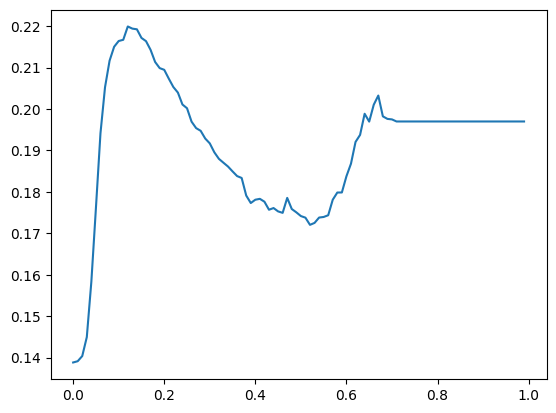

In [134]:
plt.plot(thresholds,f1_scores)

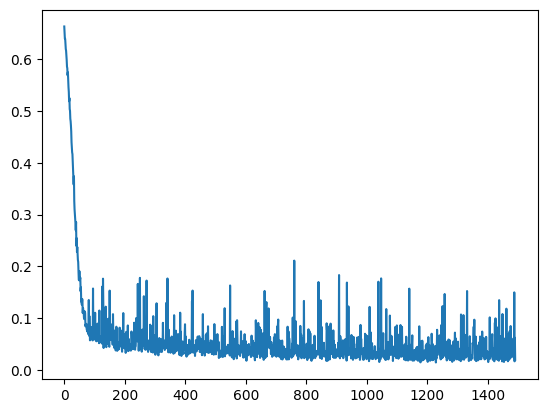

In [135]:
plt.plot(batch_losses)

In [45]:
min(batch_losses)

0.013427742756903172